# Reflexion

## Import

In [112]:
import os
from dotenv import load_dotenv

# define answer schema class
from pydantic import BaseModel, Field
from datetime import datetime

# define tool
from langchain_community.tools.tavily_search import TavilySearchResults

# define models
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    AIMessage,
    ToolMessage
)
from langchain_openai import ChatOpenAI

# define state
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import MessagesState

# define nodes
from langgraph.prebuilt import ToolNode

# define graph
from langgraph.graph import StateGraph, START, END

## Environment Variables

In [6]:
env_file_path = os.path.join("..", "..", "config", ".env")

load_dotenv(env_file_path)

True

## Implements

### Step 1 : 답변 모델 정의

In [96]:
class AnswerSchema(BaseModel):
    """
    사용자의 질문에 대해 답변을 생성하기 위해 이 도구를 활용하세요.
    """
    answer: str = Field(description="사용자 질문에 대한 이전 답변과 이전 답변에 대한 비평을 참고하여 개선한 답변")

class EvaluateSchema(BaseModel):
    missing: str = Field(description="사용자의 질문에 대한 현재 답변에서 누락되거나 부족한 부분에 대한 평가")
    superfluous: str = Field(desciption="사용자의 질문에 대한 현재 답변에서 불필요한 부분에 대한 평가")

class ReflectionSchema(BaseModel):
    reflection: str = Field(description="사용자의 질문에 대한 현재 답변에 대해 평가한 내용을 기반으로한 비평")

### Step 2 : Tool 정의

In [88]:
tavily_tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced"
)

### Step 3 : Reflextion Agent 모델 정의

In [89]:
llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0
)

In [101]:
initial_action_prompt_template = ChatPromptTemplate.from_messages([
    SystemMessage(
        content=f"""
당신은 전문 연구자 입니다. 오늘은 {datetime.today()}입니다.

당신의 임무는 다음과 같습니다.
1. 사용자의 질문에 대한 적절한 답변을 생성하세요.
2. 근거가 부족해 답변할 수 없다면 모르겠다고 답변하세요.
3. 한국어를 사용해주세요.
"""
    ),
    MessagesPlaceholder(variable_name="messages")
])

initial_action_chain = initial_action_prompt_template | llm.bind_tools(tools=[AnswerSchema, tavily_tool], tool_choice='any')

In [102]:
actor_prompt_template = ChatPromptTemplate.from_messages([
    SystemMessage(
        content=f"""
당신은 전문 연구자 입니다. 오늘은 {datetime.today()}입니다.

당신의 임무는 다음과 같습니다.
1. 사용자의 질문에 대한 적절한 답변을 생성하세요.
2. '지난 답변'과 '지난 답변에 대한 비평들'을 되돌아보고 이를 개선하여 사용자 질문에 답변하세요.
3. 근거가 부족해 답변할 수 없다면 모르겠다고 답변하세요.
4. 한국어를 사용해주세요.
"""
    ),
    MessagesPlaceholder(variable_name='context'),
    HumanMessage(content="사용자의 최초 질문과 지금까지의 행동을 되돌아보고 이를 개선하여 질문에 답변하세요.")
])

actor_chain = actor_prompt_template | llm.bind_tools(tools=[AnswerSchema, tavily_tool], tool_choice='any')

In [92]:
evaluator_prompt_template = ChatPromptTemplate.from_messages([
    SystemMessage(
        content=f"""
당신은 전문 평가자 입니다. 오늘은 {datetime.today()}입니다.

당신의 임무는 다음과 같습니다.
1. 사용자의 질문에 대해 생성한 답변에 대해 '누락되거나 부족한 부분', '불필요한 부분' 에 대해 평가하세요.
2. 개선점을 제시하는 것보다는, 어떤 점이 부족한 지 구체적으로 평가하는 것에 집중하세요.
3. 한국어를 사용해주세요.
"""
    ),
    MessagesPlaceholder(variable_name='evaluate_request')
])

evaluator_chain = evaluator_prompt_template | llm.with_structured_output(EvaluateSchema)

In [93]:
evaluator_chain.invoke({"evaluate_request" : [HumanMessage(content=f"""
최초 사용자 질문 : 
미국 대통령은 누구야?
                                                           
질문에 대한 현재 답변 :
미국 대통령은 조 바이든 입니다.
                                                
질문에 대한 현재 답변을 평가해주세요.
""")]})

EvaluateSchema(missing='현재 답변은 사용자가 질문한 시점에 대한 정보를 제공하지 않습니다. 사용자가 질문한 시점이 언제인지에 따라 대통령이 달라질 수 있으므로, 답변에 날짜나 시점을 명시하는 것이 필요합니다.', superfluous='현재 답변에는 불필요한 정보는 없습니다. 질문에 대한 직접적인 답변만을 제공하고 있습니다.')

In [75]:
self_reflection_prompt_template = ChatPromptTemplate.from_messages([
    SystemMessage(
        content=f"""
당신은 전문 컨설턴트 입니다. 오늘은 {datetime.today()}입니다.

당신의 임무는 다음과 같습니다.
1. 사용자의 질문에 대해 생성한 답변을 평가한 자료를 기반으로 더 나은 답변을 작성할 수 있도록 피드백을 작성해주세요.
2. 답변을 평가한 자료는 '사용자 질문에 대한 답변에서 누락되거나 부족한 부분', '사용자 질문에 대한 답변에서 불필요한 부분'을 기준으로 평가한 자료가 제공됩니다.
3. 한국어를 사용해주세요.
"""
    ),
    MessagesPlaceholder(variable_name="reflection_request")
])

self_reflection_chain = self_reflection_prompt_template | llm.with_structured_output(ReflectionSchema)

In [74]:
example_feedback_1 = "현재 답변은 2025년 기준으로 최신 정보를 반영하지 않고 있습니다. 2025년 6월 기준으로 미국 대통령이 조 바이든인지 확인이 필요합니다. 만약 다른 인물이라면 그에 대한 정보가 제공되어야 합니다."
example_feedback_2 = "현재 답변에는 불필요한 정보는 포함되어 있지 않습니다. 질문에 대한 직접적인 답변만을 제공하고 있습니다."

self_reflection_chain.invoke({"reflection_request" : [HumanMessage(content=f"""
최초 사용자 질문 : 
미국 대통령은 누구야?
                                                           
질문에 대한 현재 답변 :
미국 대통령은 조 바이든 입니다.
                                                           
답변에 대한 평가 자료:
1. 답변에서 누락되거나 부족한 부분 :
{example_feedback_1}
2. 답변에서 불필요한 부분 :
{example_feedback_2}
                                                
질문에 대한 현재 답변을 평가해주세요.
""")]})

ReflectionSchema(reflection='현재 답변은 2025년 6월 기준으로 최신 정보를 반영하지 않고 있습니다. 사용자가 질문한 시점에 맞춰 최신 정보를 제공하는 것이 중요합니다. 따라서, 2025년 6월 기준으로 미국 대통령이 누구인지 확인하고, 그에 따라 답변을 업데이트해야 합니다. 예를 들어, 만약 2024년 대선에서 새로운 대통령이 선출되었다면, 그에 대한 정보를 제공해야 합니다. 또한, 대통령의 임기 시작일이나 주요 정책에 대한 간단한 정보도 추가하면 사용자가 더 많은 배경 지식을 얻을 수 있습니다. 현재 답변은 불필요한 정보는 없지만, 최신 정보가 반영되지 않아 정확성이 떨어집니다. 따라서, 최신 정보를 반영하여 답변을 수정하는 것이 필요합니다.')

### Step 4 : State 정의

In [ ]:
# define States
class ReflexionState(MessagesState):
    user_query: Annotated[str, "사용자의 질문"]
    trial_num : Annotated[int, "사용자 질문에 대해 답변 생성을 시도한 횟수"]
    trajectory: Annotated[str, "사용자의 질문에 대한 현재 답변"]
    rewards: Annotated[list[str], "사용자의 질문에 대해 답변한 내용을 평가한 결과 리스트"]
    verbal_reflection: Annotated[list[str], "답변을 평가한 내용을 기반으로 작성한 피드백"]

### Step 5: Node, routing function 정의

In [189]:
# define nodes
def initial_action_node(state: ReflexionState):
    user_query = state['messages'][0].content

    if type(state['messages'][-1]) is ToolMessage:
        response = initial_action_chain.invoke({'messages' : state["messages"][-2:] + [HumanMessage(content=user_query)]})
    else:
        response = initial_action_chain.invoke({'messages' : [HumanMessage(content=user_query)]})

    return {
        "messages" : [response],
        "trial_num" : 0,
        "user_query" : user_query,
        "verbal_reflection" : []
    }

def actor_node(state: ReflexionState):

    if type(state['messages'][-1]) is ToolMessage:
        response = actor_chain.invoke({"context" : state["messages"][-2:] + [AIMessage(content=f"""
사용자 최초 질문 : 
{state['user_query']}

질문에 대한 지난 답변 :
{state['trajectory']}

답변에 대한 피드백 : 
{state['verbal_reflection']}
""")]})
    else:
        response = actor_chain.invoke({"context" : [AIMessage(content=f"""
사용자 최초 질문 : 
{state['user_query']}

질문에 대한 지난 답변 :
{state['trajectory']}

답변에 대한 피드백 : 
{'  ,  '.join(state['verbal_reflection'])}
""")]})

        
    return {"messages" : [response]}
    
    

def evaluator_node(state: ReflexionState):
    response = evaluator_chain.invoke({"evaluate_request" : [HumanMessage(content=f"""
최초 사용자 질문 : 
{state['user_query']}
                                                           
질문에 대한 현재 답변 :
{state['messages'][-1].tool_calls[0]["args"]["answer"]}
                                                
질문에 대한 현재 답변을 평가해주세요.
""")]})
    
    new_state = state.copy()
    new_state["rewards"] = [response.missing, response.superfluous]
    new_state["trajectory"] = state['messages'][-1].tool_calls[0]["args"]["answer"]
    new_state["trial_num"] += 1
    new_state["verbal_reflection"]

    return new_state
    
def self_reflection_node(state: ReflexionState):
    response = self_reflection_chain.invoke({"reflection_request" : [HumanMessage(content=f"""
최초 사용자 질문 : 
{state['user_query']}
                                                           
질문에 대한 현재 답변 :
{state['trajectory']}
                                                           
답변에 대한 평가 자료:
1. 답변에서 누락되거나 부족한 부분 :
{state['rewards'][0]}
2. 답변에서 불필요한 부분 :
{state['rewards'][1]}
                                                
질문에 대한 현재 답변을 평가해주세요.
""")]})
    
    new_state = state.copy()
    if new_state["verbal_reflection"] : 
        new_state['verbal_reflection'].append(response.reflection)
        if len(new_state['verbal_reflection']) > 3 : new_state['verbal_reflection'] = new_state['verbal_reflection'][-3:]
    else : new_state["verbal_reflection"] = [response.reflection]

    return new_state
    

initial_tool_node = ToolNode(tools=[tavily_tool])
tool_node = ToolNode(tools=[tavily_tool])

In [190]:
def initial_should_continue(state: ReflexionState):
    ai_message = state['messages'][-1]

    if hasattr(ai_message, "tool_calls") and (ai_message.tool_calls[0]["name"] == "tavily_search_results_json") : return "search"
    else : return "evaluate"

def should_continue(state: ReflexionState):
    ai_message = state['messages'][-1]

    if hasattr(ai_message, "tool_calls") and (ai_message.tool_calls[0]["name"] == "tavily_search_results_json") : return "search"
    elif state['trial_num'] > 3 : return "end"
    else : return "evaluate"

### Step 6 : Graph 정의

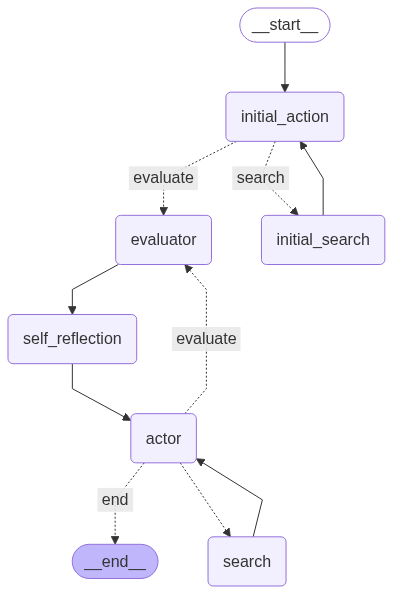

In [191]:
# define graph builder
workflow = StateGraph(ReflexionState)

# add nodes
workflow.add_node("initial_action", initial_action_node)
workflow.add_node("actor", actor_node)
workflow.add_node("evaluator", evaluator_node)
workflow.add_node("self_reflection", self_reflection_node)
workflow.add_node("initial_search", initial_tool_node)
workflow.add_node("search", tool_node)

# add edges
workflow.add_edge(START, "initial_action")
workflow.add_conditional_edges(
    "initial_action",
    initial_should_continue,
    {
        "search" : "initial_search",
        "evaluate" : "evaluator"
    }
)
workflow.add_edge("initial_search", "initial_action")
workflow.add_edge("evaluator", "self_reflection")
workflow.add_edge("self_reflection", "actor")
workflow.add_conditional_edges(
    "actor",
    should_continue,
    {
        "search" : "search",
        "end" : END,
        "evaluate" : "evaluator"
    }
)
workflow.add_edge("search", "actor")

# compile graph
app = workflow.compile()

app

### 실행

In [192]:
for event in app.stream({"messages" : [HumanMessage(content="최근 이란과 이스라엘 간의 분쟁의 원인을 정리해줘")]}):
    for node_name, state in event.items():
        print("=============", f"[Node : '{node_name}']", "=============")
        for key, value in state.items():
            print(f"    {key} : \n      {value}")
    print("\n", "============"*20, "\n")

============= [Node : 'initial_action'] =============
    messages : 
      [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AvzbAqMRqwOtyBSdXNpAvVA9', 'function': {'arguments': '{"query":"2025 이란 이스라엘 분쟁 원인"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 237, 'total_tokens': 266, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BmLzogsDb7ZhPYQOwbRc3jD8ZIJ8O', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a08eb0e7-80e8-4c38-a9b9-595f471cad8d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '2025 이란 이스라엘 분쟁 원인'}, 'id': 'call_AvzbAqMRqwOtyBSdXNpAvVA9',

## Check Result

### [질문]
최근 이란과 이스라엘 간의 분쟁의 원인을 정리해줘

---

### [최초 답변]
2025년 이란과 이스라엘 간의 분쟁은 이란의 핵 개발 프로그램이 고도화됨에 따라 발생했습니다. 국제 원자력 기구(IAEA)가 이란의 핵 비확산 의무 위반을 선언한 직후, 이스라엘은 이란의 핵 시설에 대한 공습을 감행했습니다. 이스라엘의 이러한 군사 작전은 이란의 핵 개발을 저지하기 위한 조치로, 이로 인해 이란은 전쟁 상태를 선포하고 이스라엘에 대한 즉각적인 대응을 시작했습니다. 이 분쟁은 이란의 핵 개발 능력에 대한 국제 사회의 우려와 이스라엘의 안보 위협 인식이 주요 원인으로 작용했습니다.

---

### [Reflexion Process 결과]
최근 이란과 이스라엘 간의 분쟁은 2025년 6월 13일 이스라엘이 이란의 핵시설에 대한 기습적인 폭격을 가하면서 시작되었습니다. 이스라엘의 공격은 이란의 고도화되는 핵 개발을 저지하기 위한 조치로, 이는 이스라엘의 안보에 대한 심각한 위협으로 간주되었습니다. 이 공격은 국제 원자력 기구(IAEA)가 이란의 핵 비확산 의무 위반을 선언한 직후에 발생했습니다.

이란은 이스라엘의 공격에 즉각적으로 반격하며 전쟁 상태를 선포하였고, 이로 인해 양국 간의 무력 충돌이 본격화되었습니다. 이 분쟁의 주요 원인은 다음과 같습니다:

1. **핵 개발 문제**: 이란의 핵 개발은 이스라엘에게 지속적인 위협으로 작용하고 있으며, 이스라엘은 이를 자국 안보에 대한 심각한 위협으로 보고 있습니다.

2. **역사적 적대 관계**: 이란과 이스라엘은 오랜 적대 관계를 유지해 왔으며, 이란은 이스라엘을 국가로 인정하지 않고 있습니다.

3. **정치적 이념 차이**: 이란의 이슬람주의와 이스라엘의 유대교적 가치 간의 이념적 차이는 갈등을 심화시키고 있습니다.

4. **지정학적 긴장**: 중동 지역에서의 영향력 확대를 위한 이란의 노력은 이스라엘과의 갈등을 심화시키고 있습니다.

5. **팔레스타인 문제**: 이란은 팔레스타인 무장 단체를 지원하며, 이는 이스라엘과의 긴장을 고조시키는 요인입니다.

국제 사회는 이 갈등을 중재하기 위해 다양한 노력을 기울이고 있으며, 미국은 이스라엘의 군사 작전에 지지를 표명했습니다. 그러나 양국 간의 깊은 불신과 적대감으로 인해 분쟁 해결은 쉽지 않은 상황입니다. 이 분쟁은 중동 지역의 정치적, 경제적 안정성에도 큰 영향을 미치고 있습니다.